In [11]:
import pandas as pd
import geopandas as gpd
import dbfread
import os
import zipfile

from rdfpandas.graph import to_dataframe
import rdflib



In [12]:
if not os.path.exists('./of_5529/'):
    
    from urllib.request import urlopen
    from io import BytesIO

    def download_and_unzip(url, extract_to='.'):
        http_response = urlopen(url)
        zipfile = zipfile.ZipFile(BytesIO(http_response.read()))
        zipfile.extractall(path=extract_to)

    download_and_unzip('https://ftp.maps.canada.ca/pub/nrcan_rncan/publications/STPublications_PublicationsST/223/223767/of_5529.zip',
                       './of_5529/')


<AxesSubplot:>

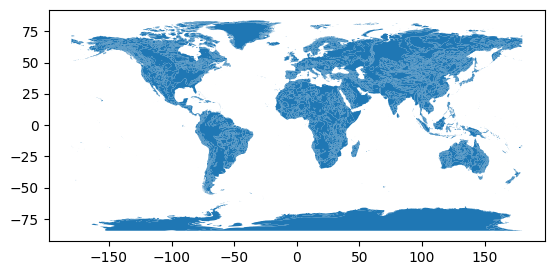

In [13]:
generalized_geology = gpd.read_file('./of_5529/data/ArcMap9_ArcReader9/AllThemesMerged/gen.shp')

generalized_geology.plot()


In [14]:
ages = gpd.pd.DataFrame(iter(dbfread.DBF('./of_5529/data/DBase_Files/rudbf/ruagedt.dbf')))

ages

,RUNO,ID2,STARTAGE,STARTQU,ENDAGE,ENDQU,RUNO_ID2,STARTCAT,ENDCAT
0,1,1,SILURIAN,,DEVONIAN,,110,SILURIAN,DEVONIAN
1,2,1,CARBONIFEROUS,,TRIASSIC,,210,CARBONIFEROUS,TRIASSIC
2,3,1,CARBONIFEROUS,,TRIASSIC,,310,CARBONIFEROUS,TRIASSIC
3,4,1,SILURIAN,,DEVONIAN,,410,SILURIAN,DEVONIAN
4,5,1,CRETACEOUS,,PALEOGENE,,510,CRETACEOUS,PALEOGENE
...,...,...,...,...,...,...,...,...,...
17686,2051,2,TERTIARY,,TERTIARY,,205120,TERTIARY,TERTIARY
17687,9859,2,PALEOZOIC,,PALEOZOIC,,985920,PALEOZOIC,PALEOZOIC
17688,9772,2,MESOZOIC,,MESOZOIC,,977220,MESOZOIC,MESOZOIC
17689,13136,1,CRETACEOUS,,CRETACEOUS,,1313610,CRETACEOUS,CRETACEOUS


In [15]:
generalized_geology_with_ages = generalized_geology.merge(ages, on='RUNO_ID2')

#generalized_geology_with_ages


In [16]:
g = rdflib.Graph()
g.parse('GTS2020.ttl', format = 'ttl')
timescale = to_dataframe(g)

timescale = timescale.rename(columns={'skos:prefLabel{Literal}@en': 'label',
                            'utf:end{Literal}(xsd:decimal)': 'end_time_ma',
                            'utf:partOf{URIRef}': 'parent',
                            'utf:start{Literal}(xsd:decimal)': 'start_time_ma'}).dropna(subset=['start_time_ma']).reset_index()

timescale = timescale[['label','start_time_ma', 'end_time_ma', 'parent']]

timescale = timescale.replace({'gts2020:': '',
                               'Juiassic': 'Jurassic'}, regex=True)

extra_times = [
    ('Paleoproterozoic', 1600., 2500., 'Proterozoic'),
    ('Mesoproterozoic', 1000., 1600., 'Proterozoic'),
    ('Neoproterozoic', 541., 1000., 'Proterozoic'),
    ('Neoarchean', 2500., 2800., 'Archean'),
    ('Archean', 2500., 4000., 'Precambrian'),
    ('Precambrian', 541., 4600., 'None'),
    ('Proterozoic', 541., 2500., 'Precambrian'),
    ('Paleoarchean', 3200., 3600., 'Archean'),
    ('Mesoarchean', 2800., 3200., 'Archean'),
    ('Recent', 0., 2.58, 'Cenozoic'),
    ('Riphean', 600., 1600., 'Neoproterozoic'),
    ('Eoarchean', 3600., 4000., 'Archean'),
    ('Vendian', 541., 635., 'Neoproterozoic'),
    ('Tertiary', 2.58, 66., 'Cenozoic')]

pd.DataFrame(data=extra_times, columns=timescale.columns)

timescale = pd.concat([timescale,
                       pd.DataFrame(data=extra_times, columns=timescale.columns)],
                      ignore_index=True
                )

timescale


,label,start_time_ma,end_time_ma,parent
0,5stages,0.0,0.78,Pleistocene
1,Aalenian,170.9,174.7,MiddleJurassic
2,Aeronian,438.6,440.5,Llandovery
3,Age10,486.9,491.0,Furongian
4,Age2,521.0,529.0,Terreneuvian
...,...,...,...,...
162,Recent,0.0,2.58,Cenozoic
163,Riphean,600.0,1600.0,Neoproterozoic
164,Eoarchean,3600.0,4000.0,Archean
165,Vendian,541.0,635.0,Neoproterozoic


In [17]:
import numpy as np

def start_age_ma(name):
    match = timescale['label'].str.match(name, case=False)
    if any(match):
        return np.float64(timescale[match]['start_time_ma'])
    else:
        return np.nan

def end_age_ma(name):
    match = timescale['label'].str.match(name, case=False)
    if any(match):
        return np.float64(timescale[match]['end_time_ma'])
    else:
        return np.nan


generalized_geology_with_ages['FROMAGE'] = generalized_geology_with_ages['STARTAGE'].apply(end_age_ma)
generalized_geology_with_ages['TOAGE'] = generalized_geology_with_ages['ENDAGE'].apply(start_age_ma)


In [18]:
if not os.path.exists('./global_geology_shapefile'):
    os.makedirs('./global_geology_shapefile')
    
generalized_geology_with_ages.to_file('./global_geology_shapefile/nrcan_geology_with_ages.shp')


In [19]:
def create_zip_from_directory(source_dir, output_zip):
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(source_dir):
            for file in files:
                file_path = os.path.join(root, file)
                rel_path = os.path.relpath(file_path, source_dir)
                zipf.write(file_path, rel_path)
                
create_zip_from_directory('./global_geology_shapefile', 
                          './global_geology_shapefile.zip')
